# Weather station data limit detection

This document is meant to illustrate QA method applied to our first version of public weather observation, https://data.planetos.com/datasets/noaa_synop2

In the first iteration we apply a simple QA, based on 15 year data history and statistical distribution analysis. This way we can filter out a portion of clearly bad values, but a large number of suspicious values are not discovered by tis method. 

For statistical distribution, we take a simple approach, find the 05, 95 quantiles for each station by month, find their difference and use the difference + certain multiplier above the 95 and below the 05 quantiles, as boundaries for accepting values. This way we get very few or no false positives for variables like temperature and pressure, but a significant amount of false negatives remain in the data.

In [5]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests
import time
import pickle

from ipywidgets import FloatProgress
from IPython.display import display

from API_client.python.datahub import datahub
from API_client.python.lib.dataset import dataset

In [6]:
month = 8

In [8]:
data_file_path = '' ## insert data file path here
%%time
dtypes = {'cloud_below_station_type':str,
          'cloud_location_type_AC':str,
          'cloud_location_type_AS':str,
          'cloud_location_type_CB':str,
          'cloud_location_type_CI':str,
          'cloud_location_type_CS':str,
          'cloud_location_type_CU':str,
          'cloud_location_type_ST':str,
          'cloud_location_type_SC':str,
          'cloud_type_high_compass_dir':str,
          'cloud_type_low_compass_dir':str,
          'cloud_type_middle_compass_dir':str,
          'hoar_frost':str,
          'hoar_frost_phenom_descr':str,
          'weather_present_simple':str,
          'state_of_ground_snow':str}
#fls = glob.glob('/data/files/eneli/synop_data_state_csv_metaf2xml/2018/5/*/*')

fls = glob.glob(data_file_path + '/20??/{0}/*'.format(month))
fin_csvs = []
usecols = ['time','station','pressure','temperature','station_pressure']
f = FloatProgress(min = 0, max = len(fls))
display(f)
for i in fls:
    try:
        fin_csvs.append(pd.read_csv(i, usecols=usecols, dtype=dtypes))
    except:
        print("cannot read ", i)
        with open(i) as fff:
            print(len(fff.readlines()))
    f.value += 1
fin = pd.concat(fin_csvs)

FloatProgress(value=0.0, max=550.0)

cannot read  /data/files/eneli/synop_data_history_decoded/2012/8/201208280000_201208290000.csv
1
cannot read  /data/files/eneli/synop_data_history_decoded/2012/8/201208290000_201208300000.csv
1
46167885
CPU times: user 2min 42s, sys: 25.2 s, total: 3min 8s
Wall time: 3min 53s


In [9]:
stations = fin['station'].unique()

In [10]:
physical_limits = {
    "temperature": [-80, 65],
    "wind_speed": [0, 90],
    "pressure": [800,1100],
    "station_pressure": [400,1100],
    "precipitation_1_hour_accumulation": [0,200],
    "precipitation_2_hour_accumulation": [0,250],
    "precipitation_3_hour_accumulation": [0,400],
    "precipitation_6_hour_accumulation": [0,400],
    "precipitation_9_hour_accumulation": [0,400],
    "precipitation_12_hour_accumulation": [0,400],
    "precipitation_15_hour_accumulation": [0,400],
    "precipitation_18_hour_accumulation": [0,400],
    "precipitation_24_hour_accumulation": [0,400],
    "rel_humidity1":[0,105],
    "rel_humidity2":[0,105],
    "rel_humidity3":[0,105],
    "rel_humidity4":[0,105]
  }

In [ ]:
## st_table -- statistics of observations by station and month

%%time
st_table = {}
f = FloatProgress(min = 0, max = len(stations))
display(f)
for st in stations:
    stn = "{0:05d}".format(int(st))
    st_table[stn] = {}
    t_temp = fin[fin['station'] == st]
    varis = [i for i in t_temp.columns if not i in ['time','elevation','lon','lat','station']]
    f.value+=1
    for v in varis:
        v_temp = t_temp[v]
        if v_temp.dtype == np.float64:
            st_table[stn][v] = {}
            if ~np.all(v_temp.isnull()):
                st_table[stn][v] = {}
                st_table[stn][v][v+'_max'] = v_temp.max()
                st_table[stn][v][v+'_min'] = v_temp.min()
                st_table[stn][v][v+'_count'] = len(v_temp)
                st_table[stn][v][v+'_quantiles'] = list(v_temp.quantile([0.05,0.25,0.5,0.75,0.95]))

FloatProgress(value=0.0, max=11610.0)

In [13]:
def make_limit_dictionary(stations, physical_limits, monthlist, varlist):
    ret_dict = {}
    for st in stations:
        stn = "{0:05d}".format(int(st))
        ret_dict[stn] = {}
        for mon in monthlist:
            ret_dict[stn][mon] = {}
            for var in varlist:
                ret_dict[stn][mon][var] = {}
                if var in physical_limits:
                    ret_dict[stn][mon][var][var+'_max'] = physical_limits[var][1]
                    ret_dict[stn][mon][var][var+'_min'] = physical_limits[var][0]
    return ret_dict

In [14]:
## limit_dict -- dictionary with stations and limitations
%%time
## cols = [i for i in fin.columns if not i in ['time','elevation','lon','lat','station','station_name','report_modifier','station_name','station_type','synop_code']]
monthlist=list([month,])
limit_dict = make_limit_dictionary(stations, physical_limits, monthlist, physical_limits.keys())

CPU times: user 248 ms, sys: 40.7 ms, total: 289 ms
Wall time: 288 ms


In [15]:
def add_criteria(station, month, variable, st_table, limit_dict):
    def get_vbounds():
        if variable == 'temperature':
            maxmindiff = 3 * (st_table[station][variable][variable + '_quantiles'][4] - st_table[station][variable][variable + '_quantiles'][0])
            vmax = maxmindiff + st_table[station][variable][variable + '_quantiles'][4]
            vmin = -maxmindiff + st_table[station][variable][variable + '_quantiles'][0]
        elif variable in ['station_pressure', 'pressure']:
            vmax = st_table[station][variable][variable + '_quantiles'][4] * 1.05
            vmin = st_table[station][variable][variable + '_quantiles'][0] / 1.05        
        else:
            vmax = st_table[station][variable][variable + '_quantiles'][4] * 1.5
            vmin = st_table[station][variable][variable + '_quantiles'][0] / 1.5
        return vmax, vmin   
    assert type(station) == str
    assert type(variable) == str
    assert type(st_table) == dict
    
    if not variable in st_table[station]:
        #print("no variable, returning", variable)
        return
    
    ## if data is too sparse, better leave it
    if not variable + '_count' in st_table[station][variable]:
        return
    
    if st_table[station][variable][variable + '_count'] < 2000:
        return
    
    if variable + '_max' in st_table[station][variable]:
        #print("var found", variable)
        #vmax = st_table[station][variable][variable + '_quantiles'][4] * 1.5
        #vmin = st_table[station][variable][variable + '_quantiles'][0] / 1.5
        vmax, vmin = get_vbounds()
        if not variable + '_max' in limit_dict[station][month][variable]:
            limit_dict[station][month][variable][variable + '_max'] = vmax
            limit_dict[station][month][variable][variable + '_min'] = vmin
        else:
            if limit_dict[station][month][variable][variable + '_max'] > vmax:
                limit_dict[station][month][variable][variable + '_max'] = vmax
            if limit_dict[station][month][variable][variable + '_min'] < vmin:
                limit_dict[station][month][variable][variable + '_min'] = vmin
    else:
        pass
        ##print("var not found in",st_table[station][variable], variable)
        

Combine statistics and hard limits

In [16]:
%%time
for strange in range(len(stations)):
    for i in limit_dict["{0:05d}".format(stations[strange])][month].keys():
        add_criteria("{0:05d}".format(stations[strange]),month,i,st_table, limit_dict)

CPU times: user 562 ms, sys: 0 ns, total: 562 ms
Wall time: 562 ms


Dump the file for later use

In [58]:
pickle.dump(limit_dict, open('limit_dict_{0}.pickle'.format(month),'wb'))

Helper methods to plot the problematic data

In [23]:
# var = 'station_pressure'
def find_stlistike():
    stlistike = []
    f = FloatProgress(min=0, max=len(stations))
    display(f)
    var = 'pressure'
    for st in range(len(stations)):
        if np.any(fin[fin['station']==stations[st]][var] > limit_dict["{0:05d}".format(stations[st])][month][var][var + '_max']):
            print(st,)
            stlistike.append(st)
        f.value += 1
    return stlistike

In [18]:
def plot_suspicious(var, stlistike):
    for st in stlistike:
        trtr = fin[fin['station']==stations[st]][['time',var,'station']].drop_duplicates().sort_values('time')    
        trtr['datetime'] = (trtr['time']*1.e9).apply(pd.to_datetime)
        fig=plt.figure(figsize=(15,10))
        plt.plot(trtr['datetime'],trtr[var],'*')
        plt.plot(trtr['datetime'],np.ones(len(trtr))*limit_dict["{0:05d}".format(stations[st])][month][var][var + '_max'])
        plt.plot(trtr['datetime'],np.ones(len(trtr))*limit_dict["{0:05d}".format(stations[st])][month][var][var + '_min'])
        plt.title("{0}   {1}".format(st, len(trtr.index)))
    plt.show()

In [19]:
def check_suspicious(var, st):
    st = 410
    fig=plt.figure(figsize=(15,10))
    trtr = fin[fin['station']==stations[st]][['time',var,'station']].drop_duplicates().sort_values('time')
    trtr['datetime'] = (trtr['time']*1.e9).apply(pd.to_datetime)
    trfilt=trtr[trtr['datetime'].apply(lambda x: x.year) == 2010]
    print(len(trfilt))
    plt.plot(trfilt['datetime'],trfilt['temperature'])
    plt.show()

In [24]:
stl = find_stlistike()

FloatProgress(value=0.0, max=11610.0)

45
54
108
216
240
270
344
496
522
701
703
704
793
812
932
1008
1058
1264
1290
1293
1309
1388
1389
1392
1393
1394
1395
1400
1403
1405
1407
1422
1482
1483
1494
1515
1548
1552
1557
1588
1599
1622
1623
1634
1638
1645
1661
1679
1680
1684
1691
1695
1699
1704
1711
1715
1717
1722
1724
1728
1732
1738
1742
1743
1745
1751
1752
1756
1760
1769
1771
1777
1778
1792
1834
1836
1857
1869
1882
1884
1885
1889
1897
1899
1904
1907
1915
1916
1918
1923
1924
1925
1926
1931
1941
1944
1949
1950
1969
1973
1974
1975
1977
1981
2010
2013
2014
2015
2025
2027
2035
2043
2058
2063
2066
2099
2109
2110
2115
2128
2131
2136
2141
2144
2146
2152
2154
2157
2158
2162
2163
2167
2175
2176
2178
2180
2184
2198
2201
2202
2203
2205
2206
2211
2212
2218
2231
2234
2238
2240
2241
2243
2245
2273
2288
2296
2312
2314
2323
2325
2326
2333
2334
2335
2341
2347
2349
2351
2358
2363
2367
2368
2370
2378
2379
2382
2383
2390
2392
2393
2395
2402
2403
2404
2405
2407
2408
2409
2411
2415
2416
2419
2420
2422
2426
2430
2431
2432
2434
2435
2437
2438
2439
24

/home/aluhamaa/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


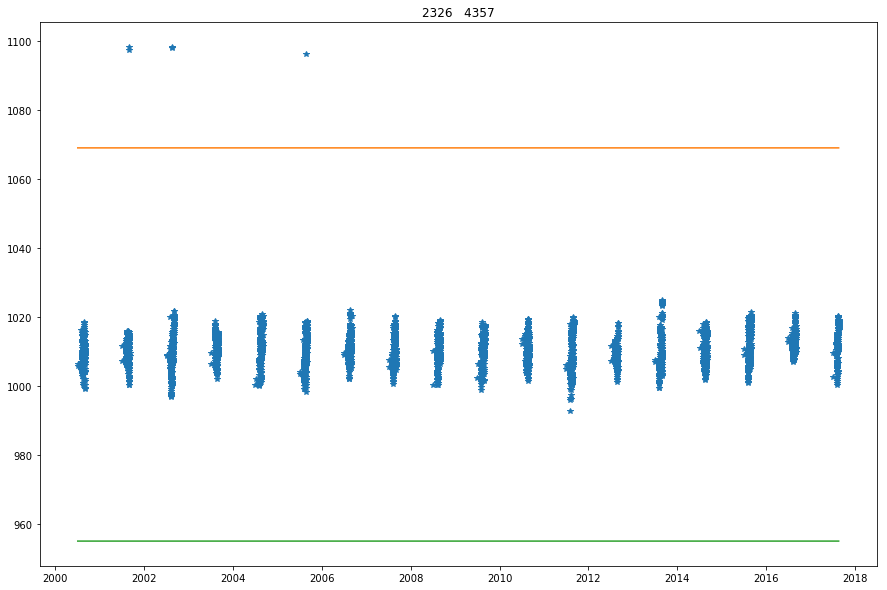

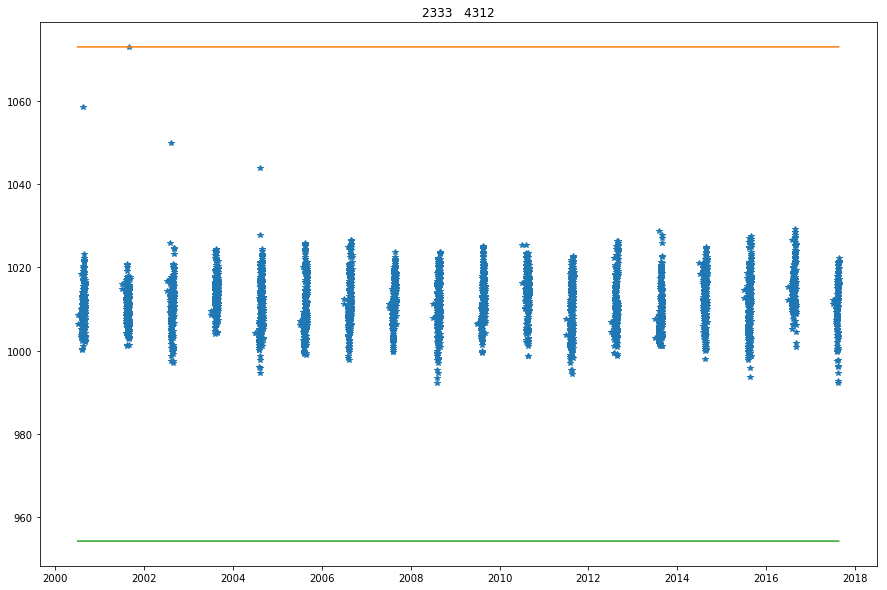

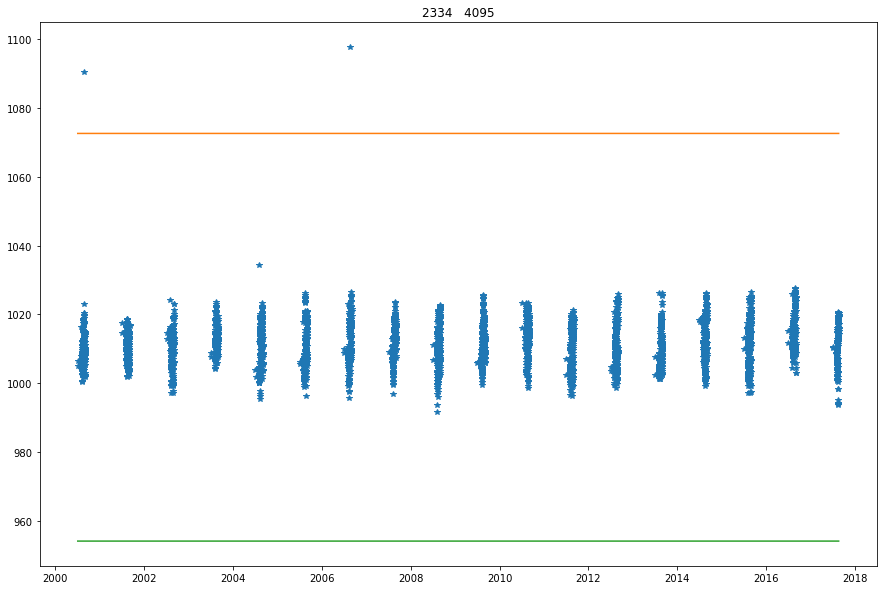

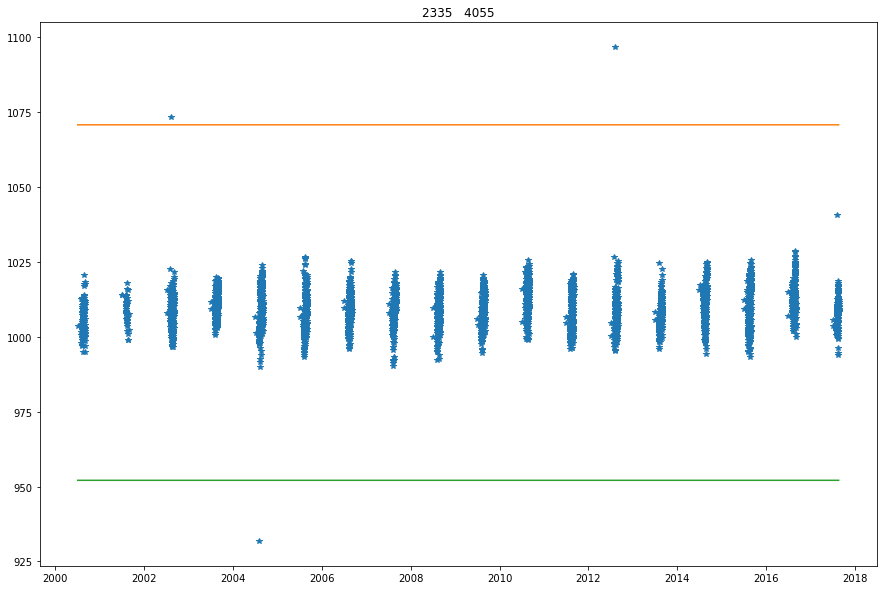

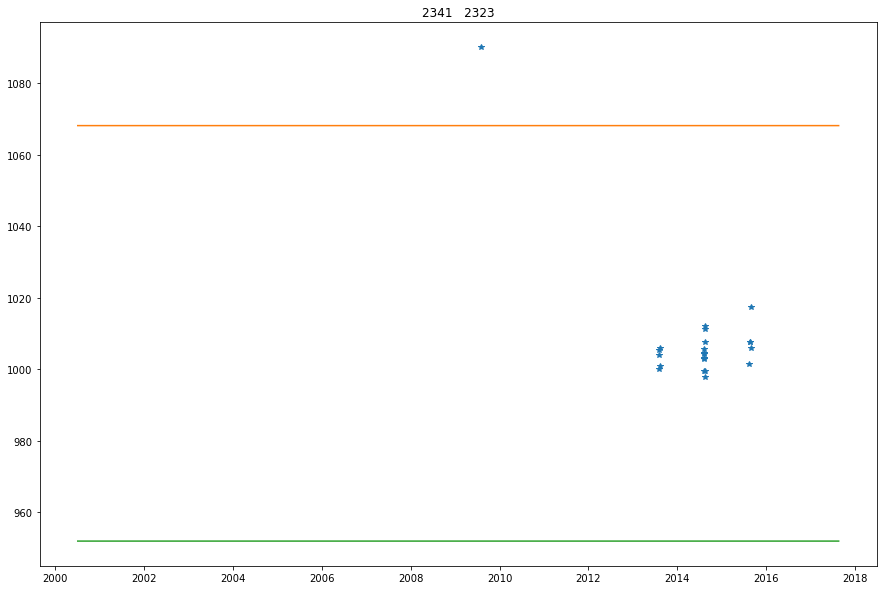

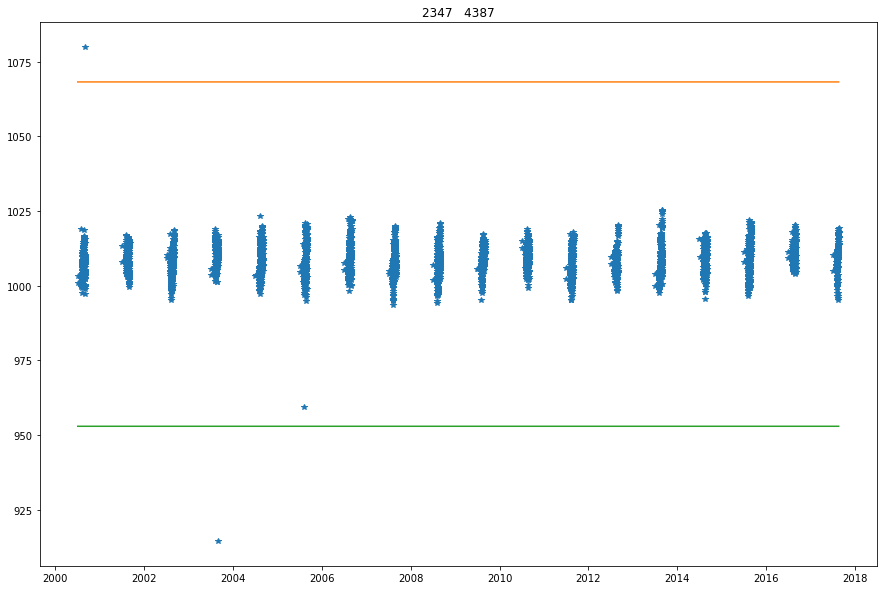

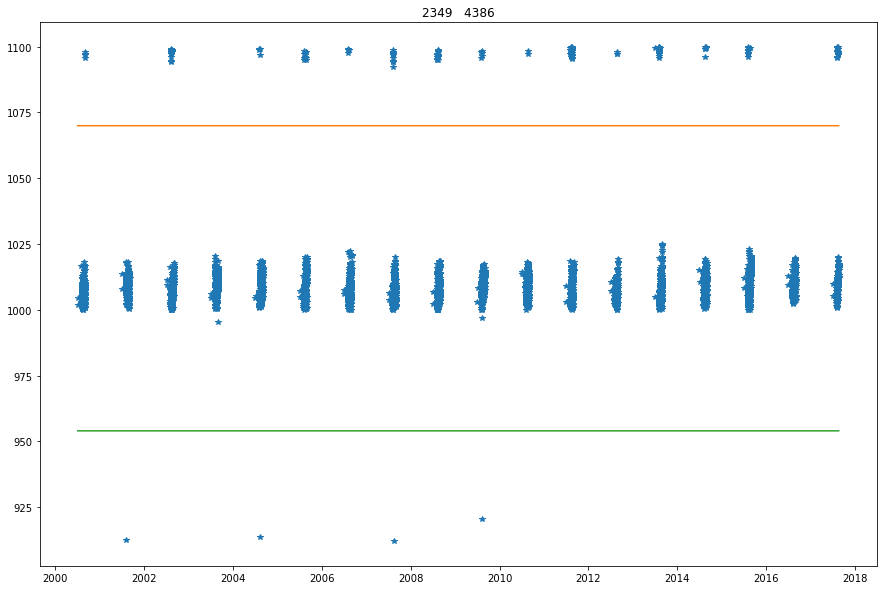

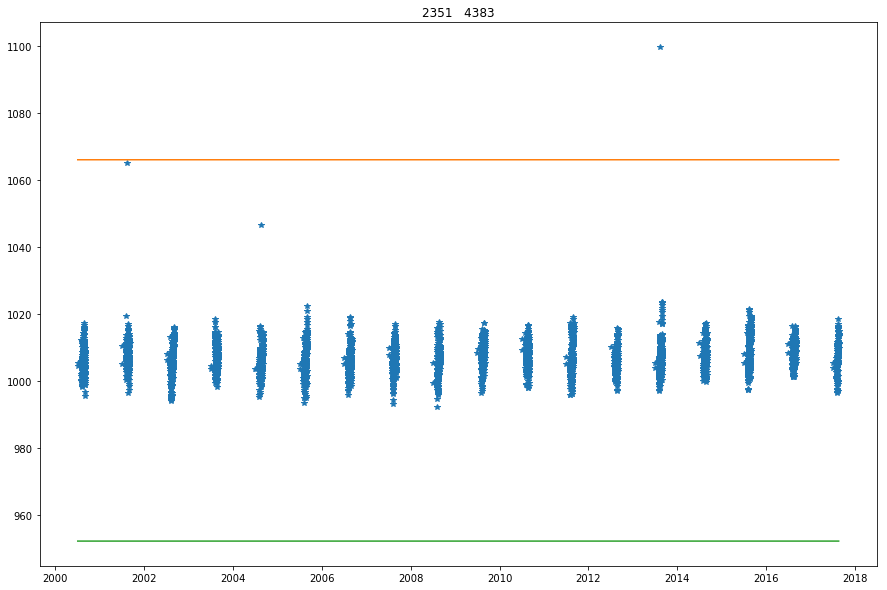

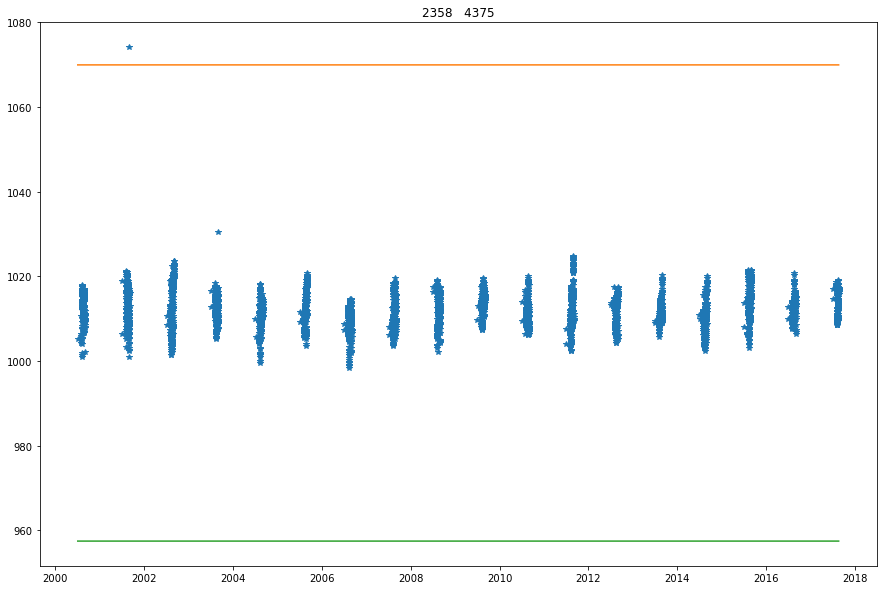

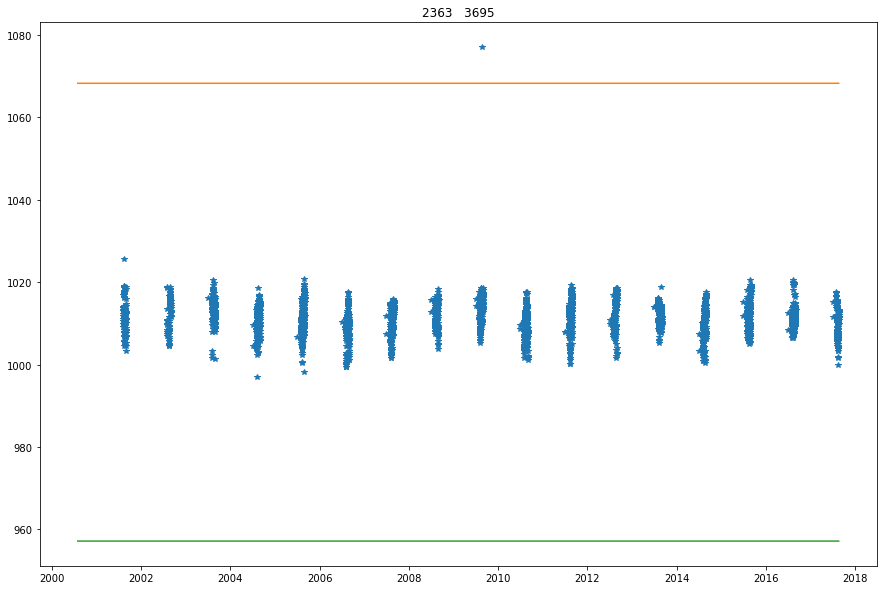

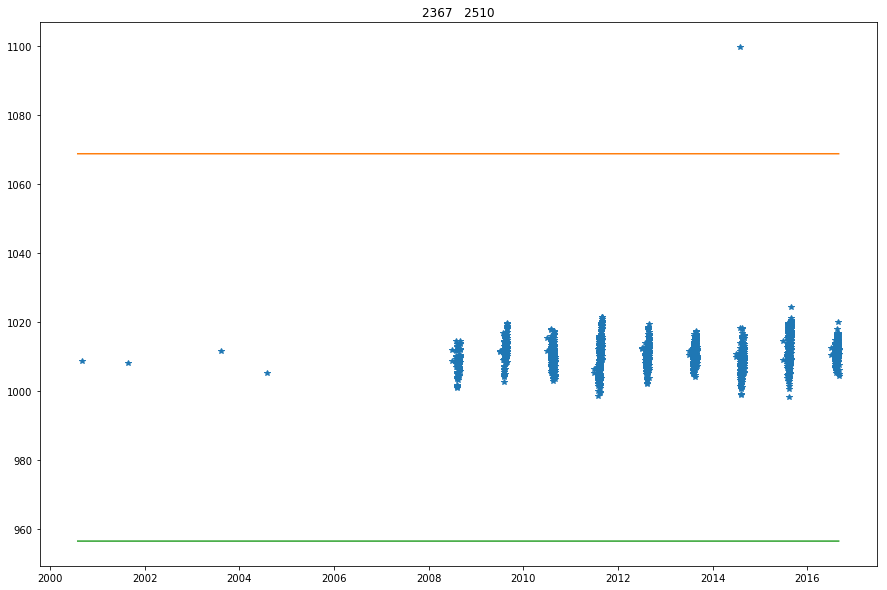

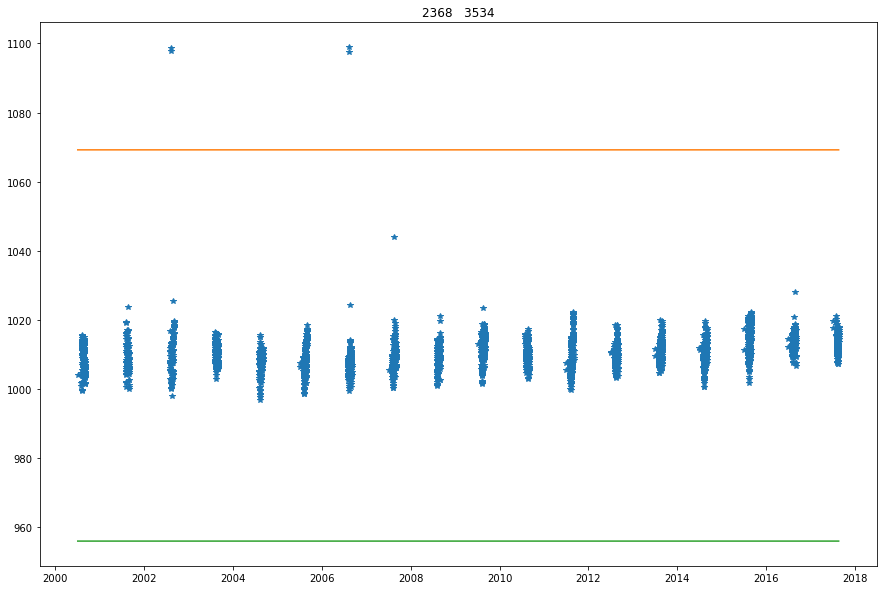

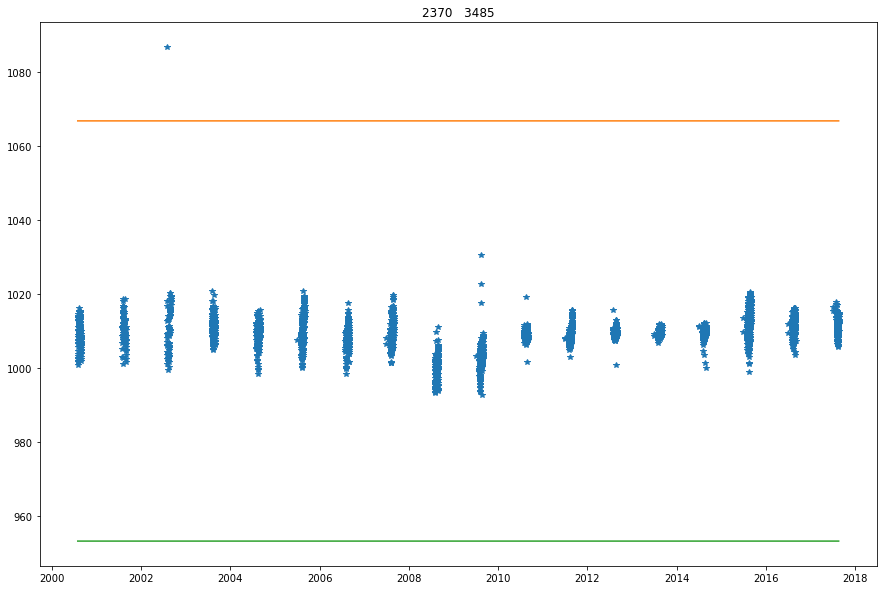

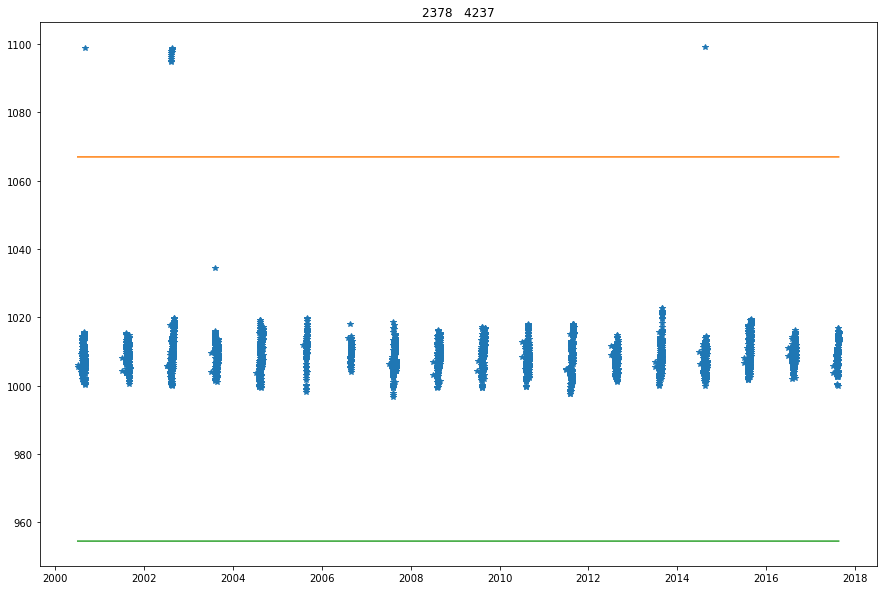

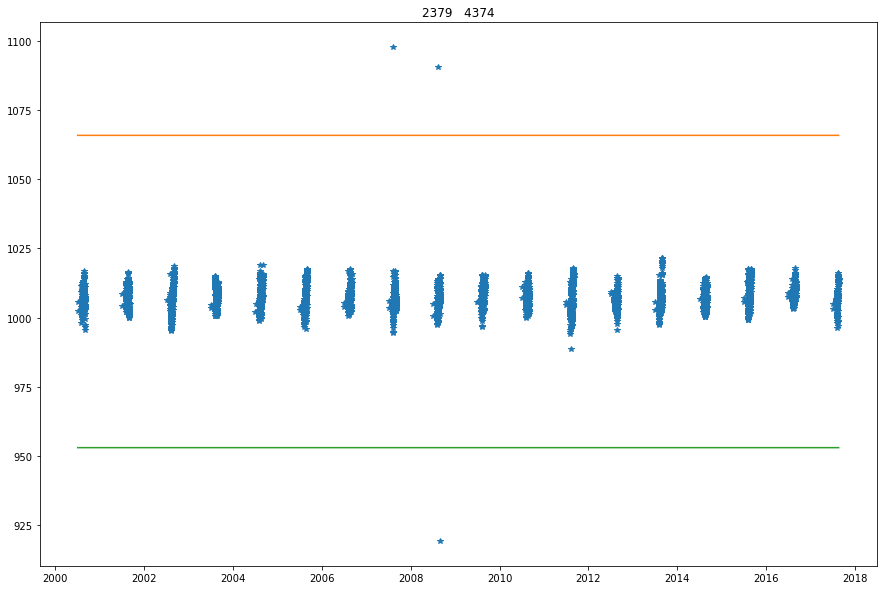

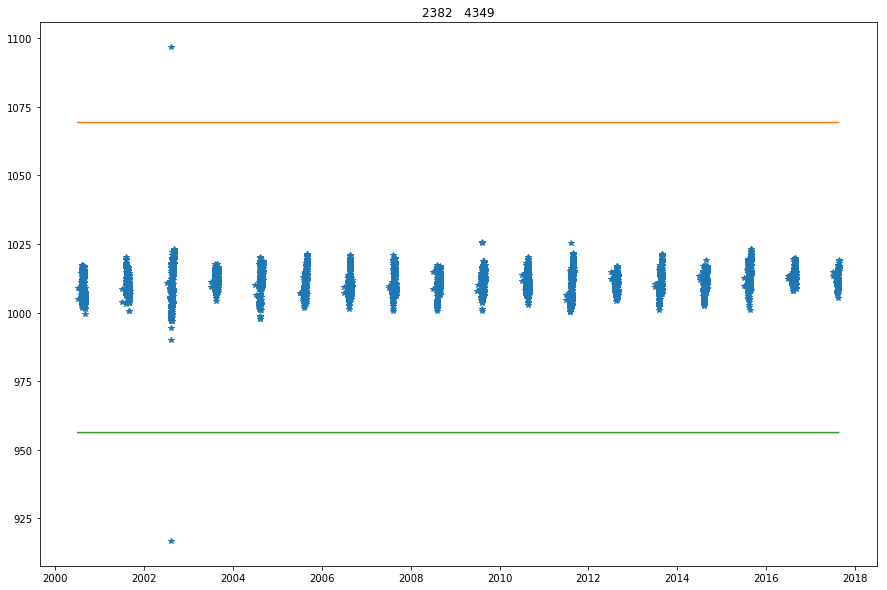

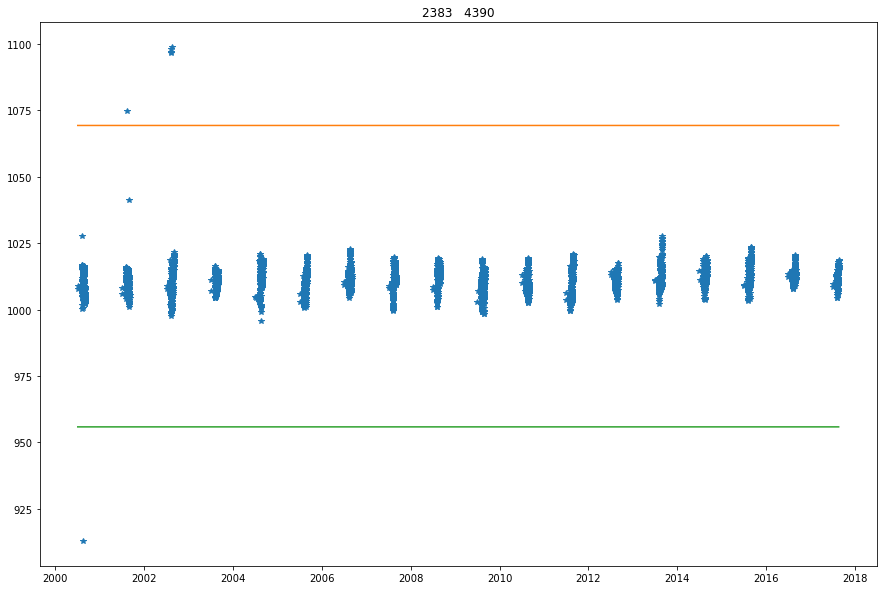

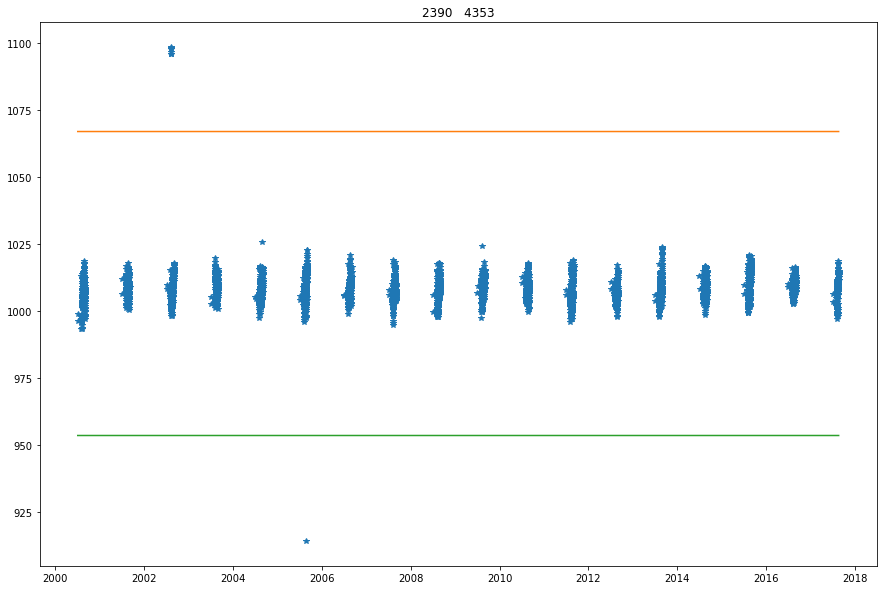

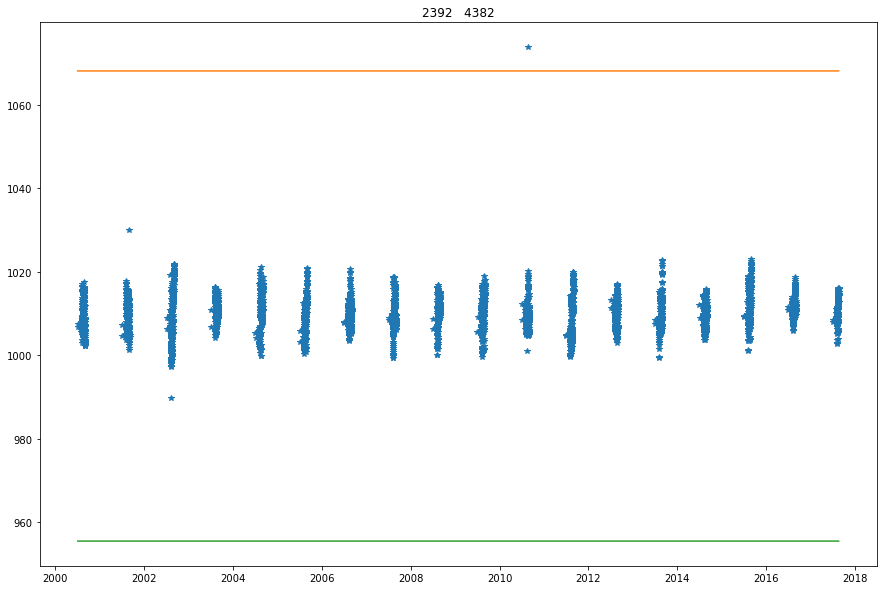

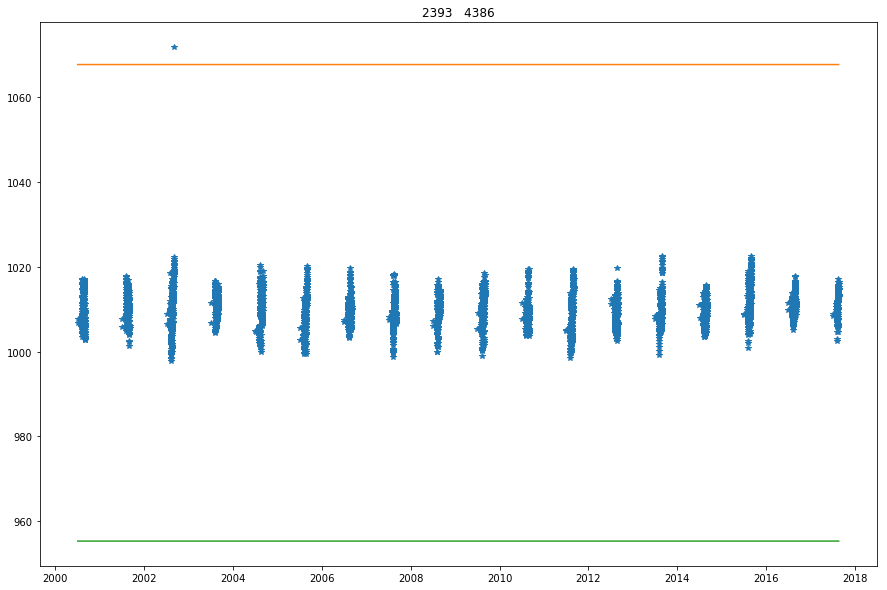

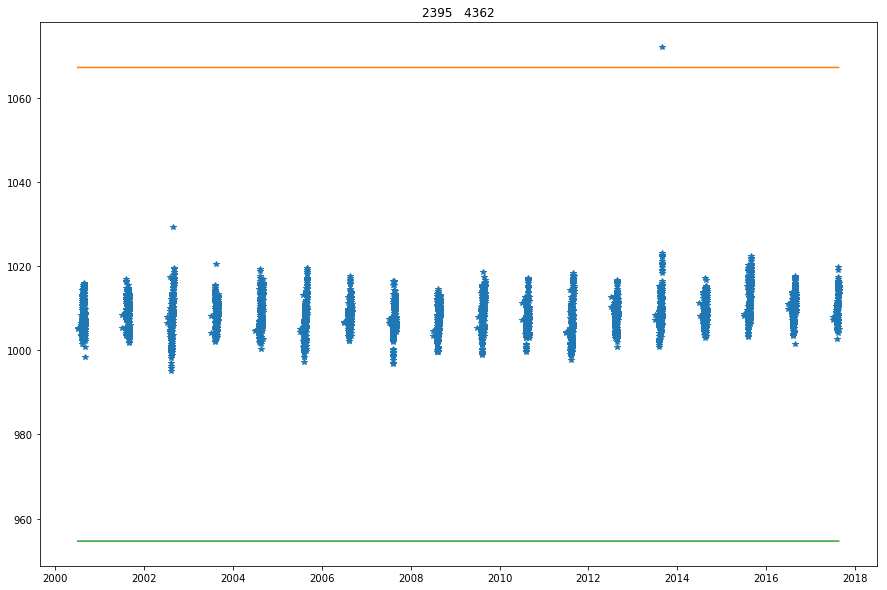

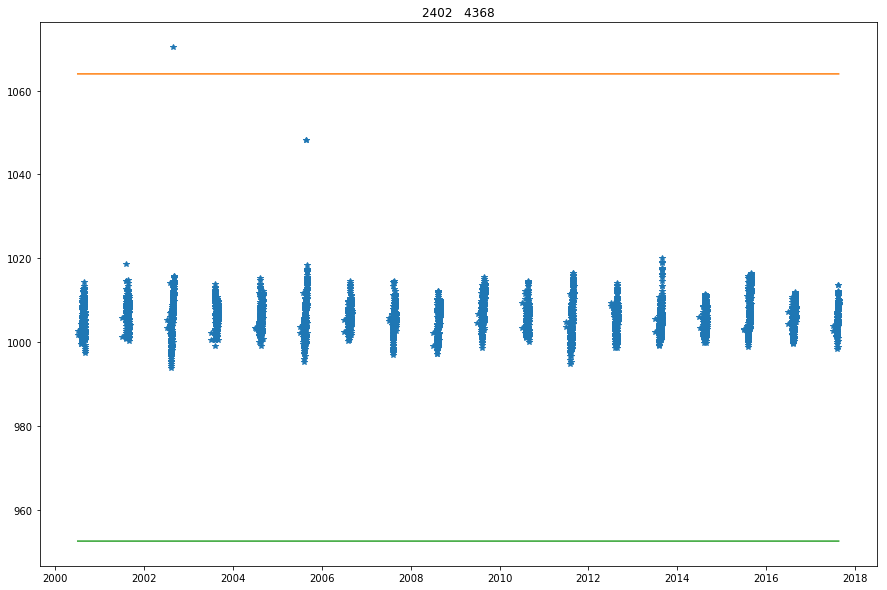

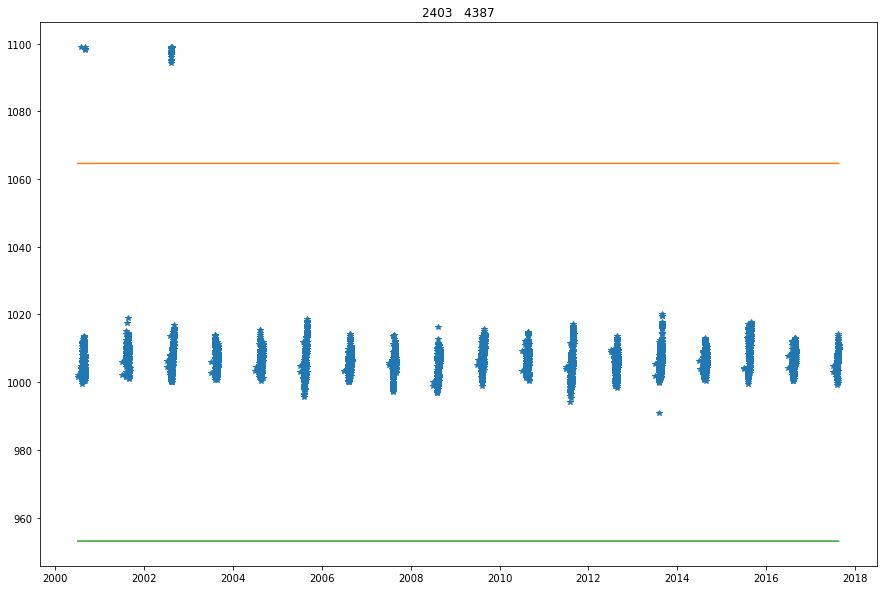

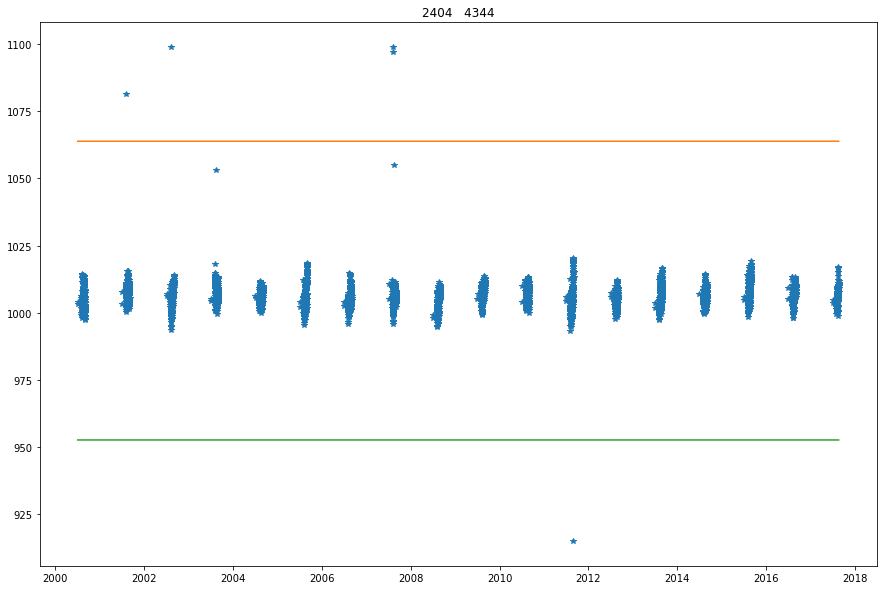

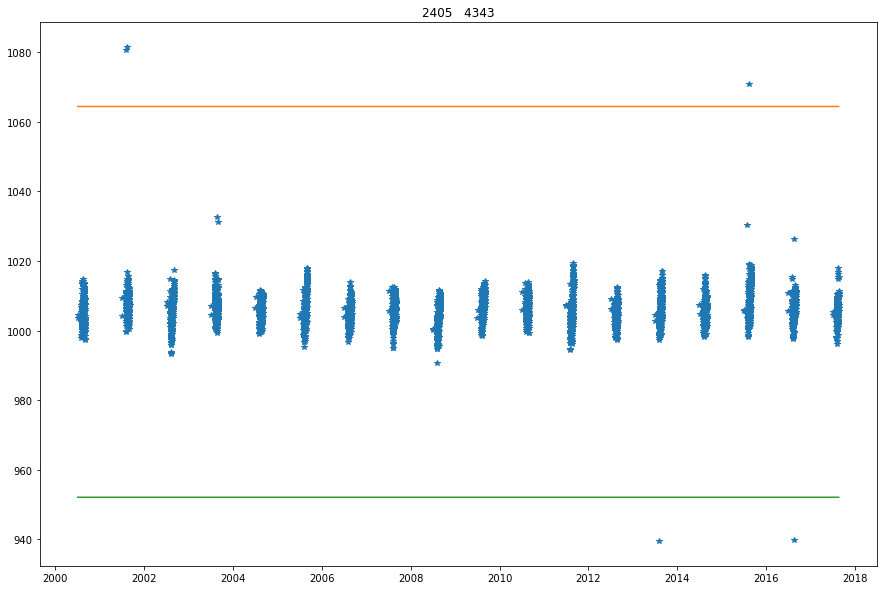

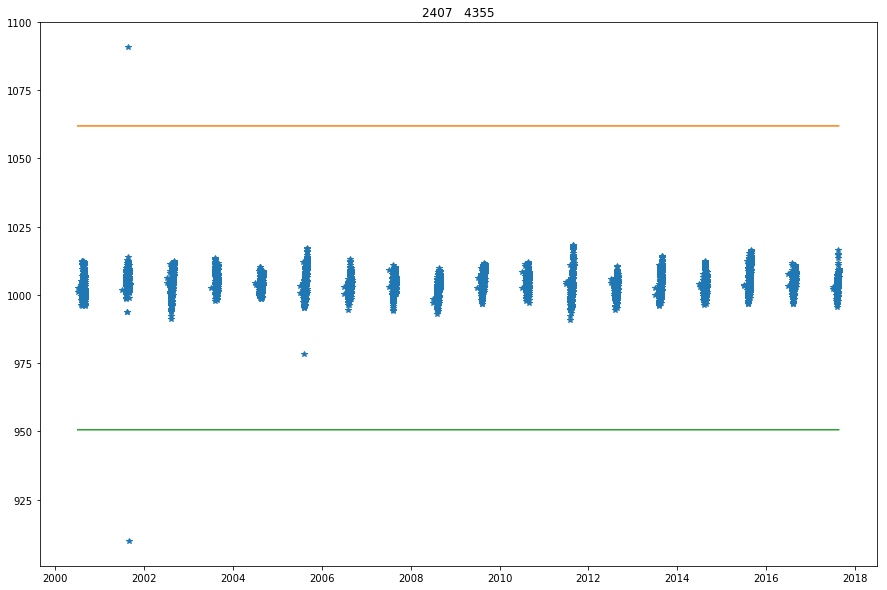

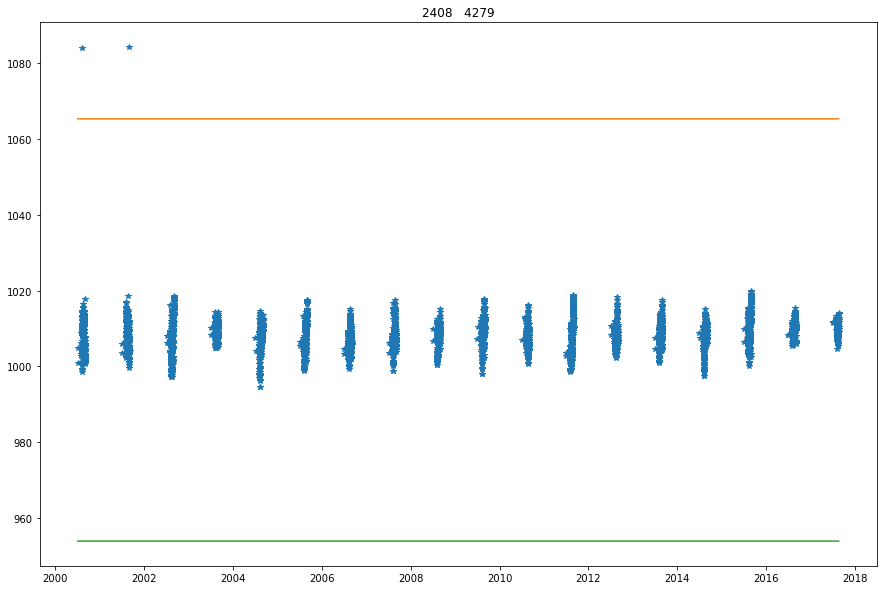

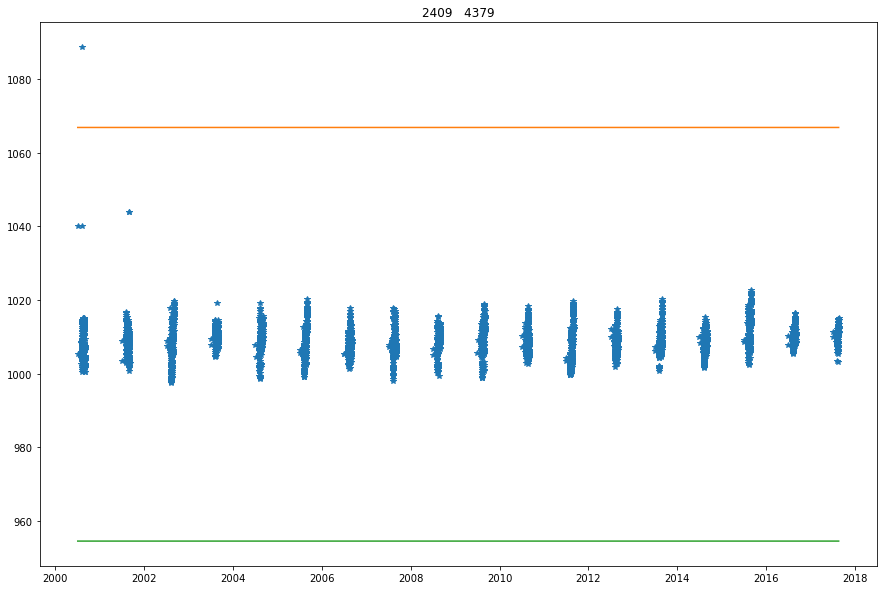

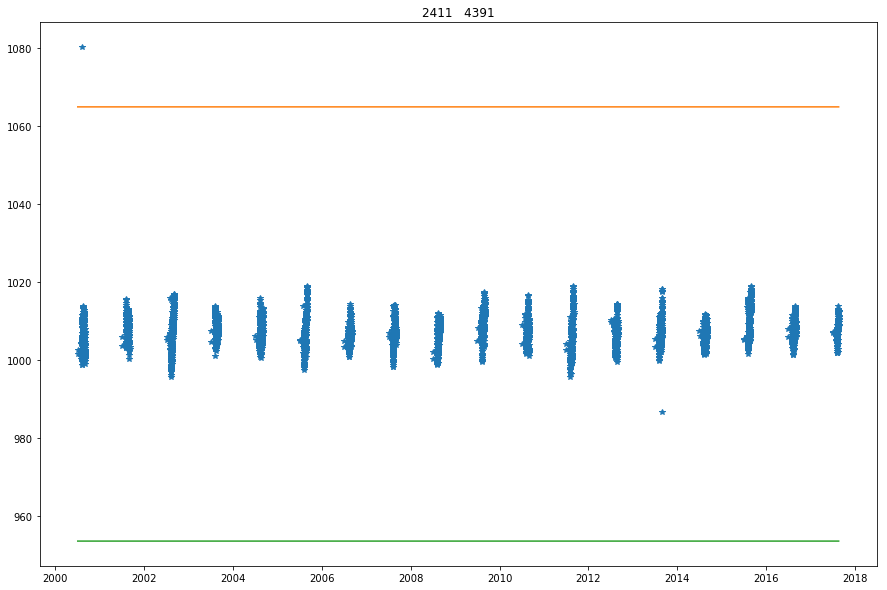

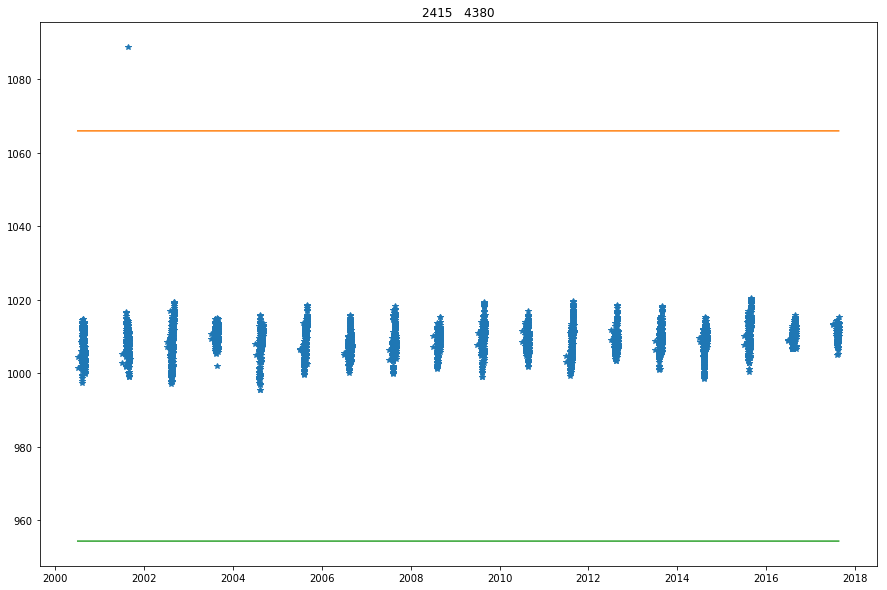

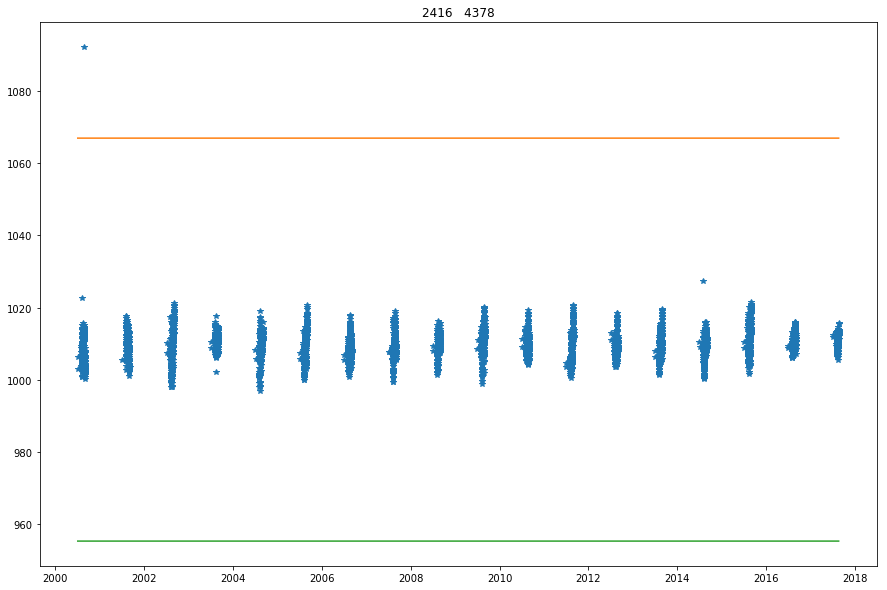

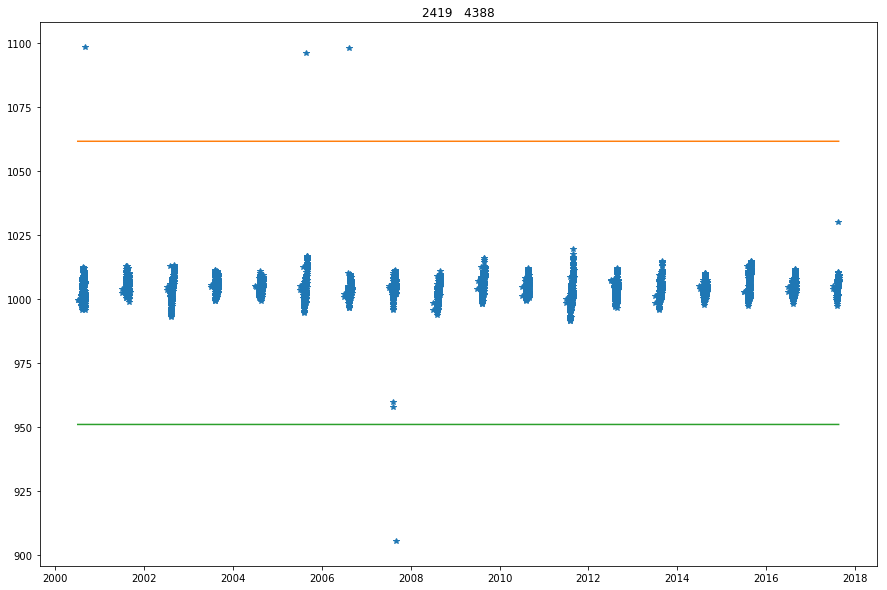

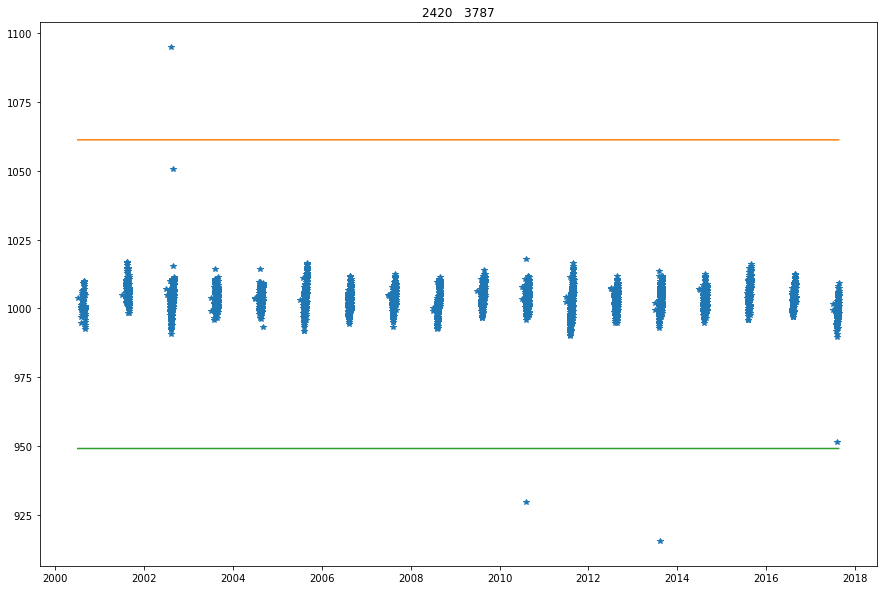

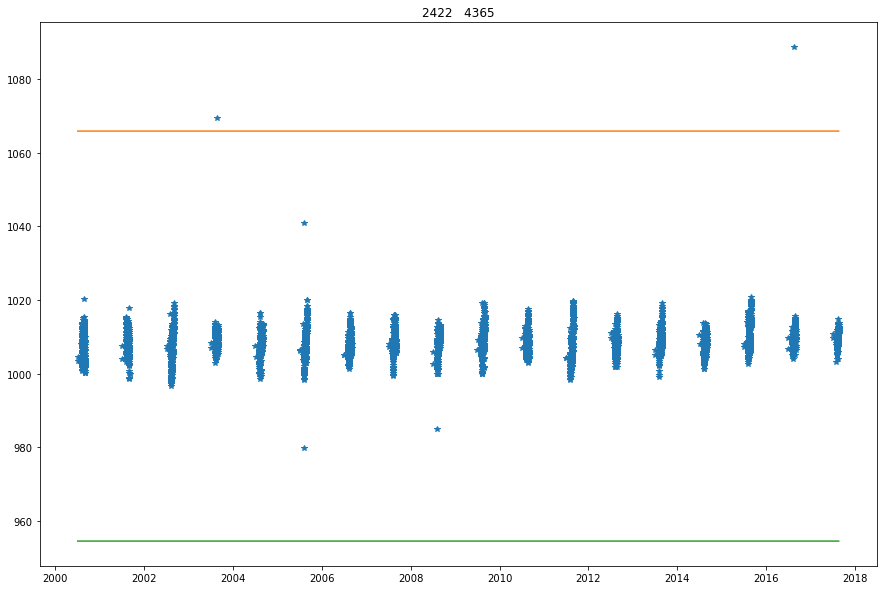

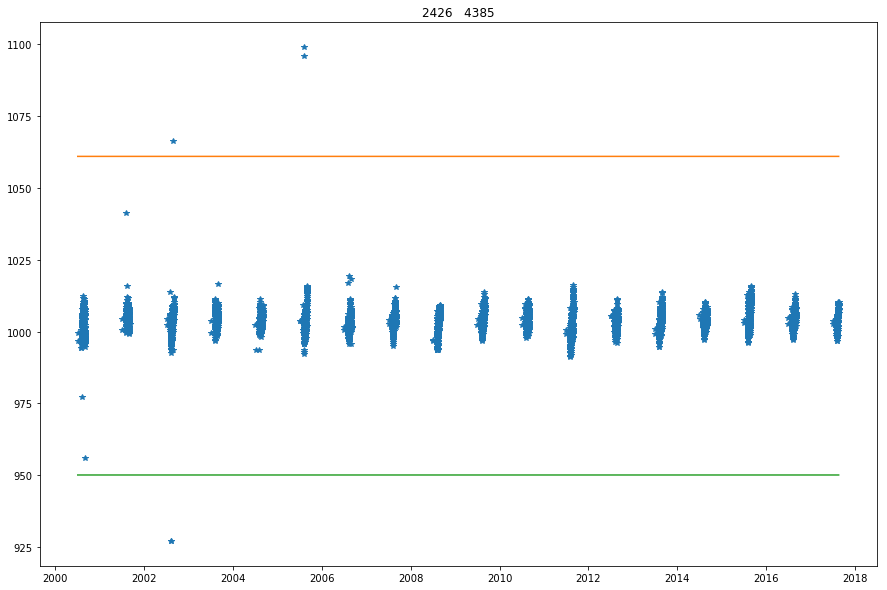

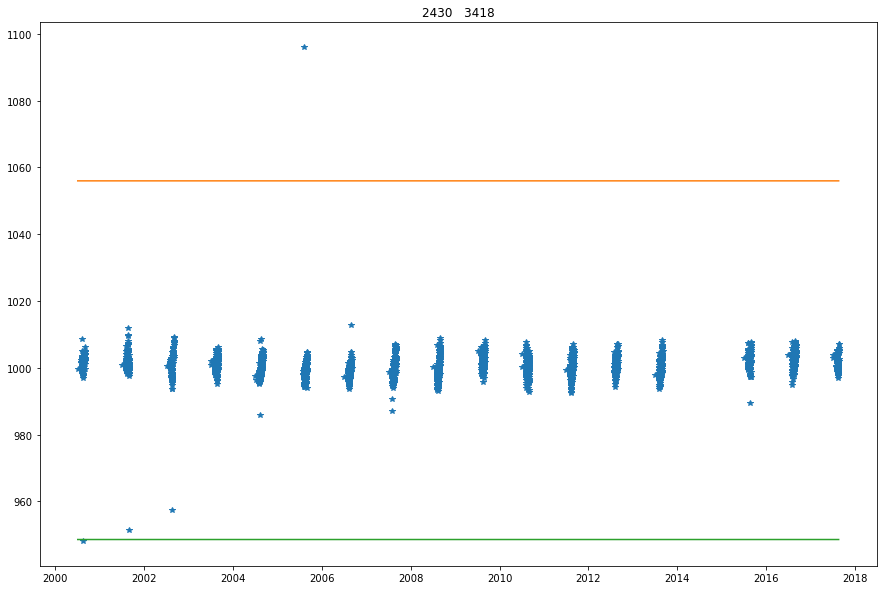

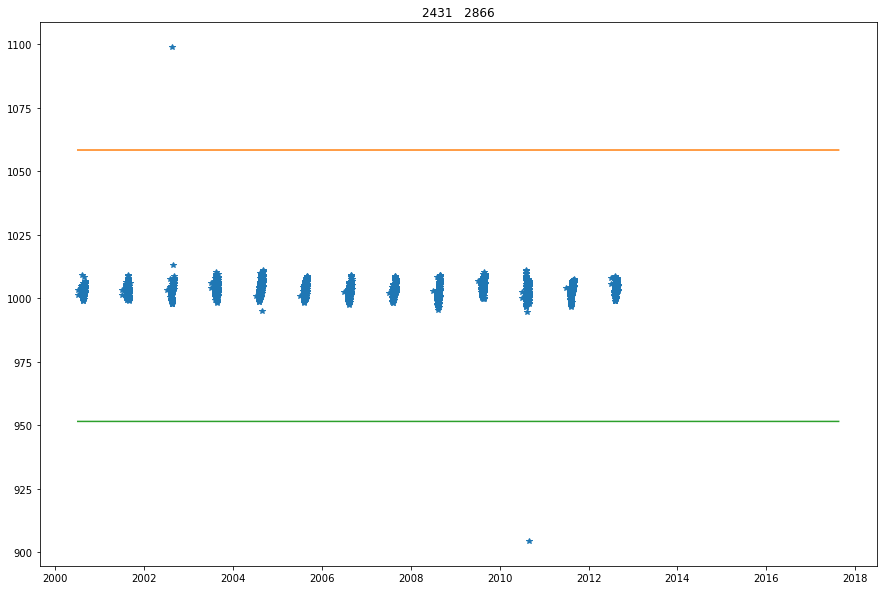

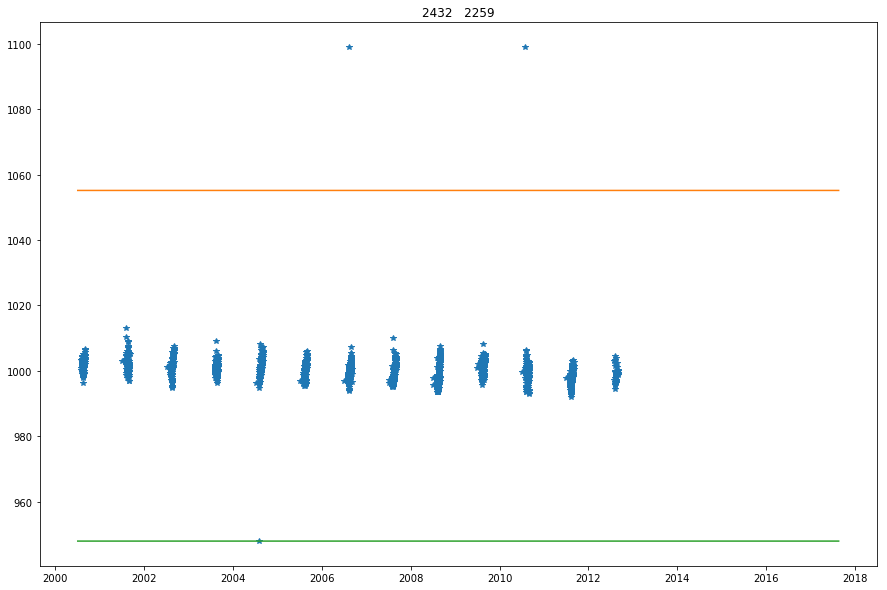

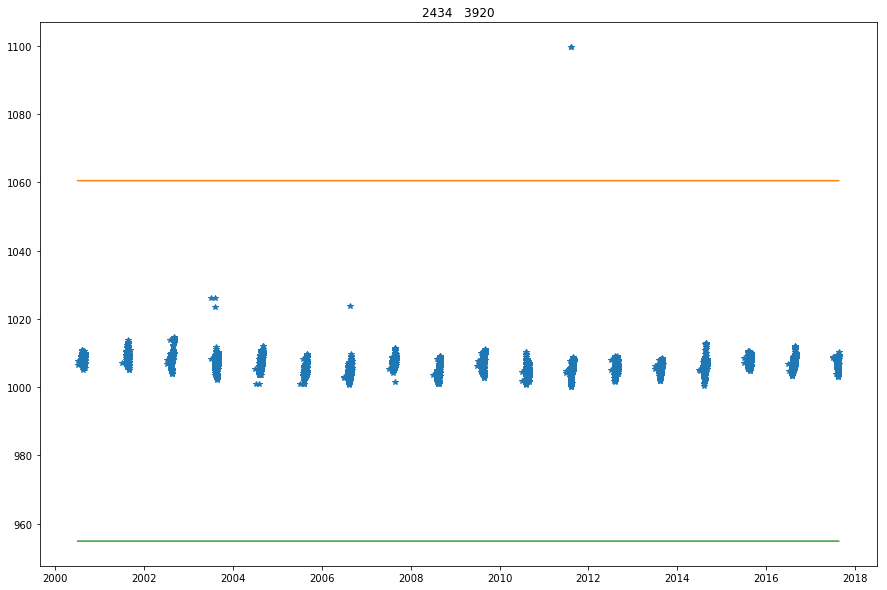

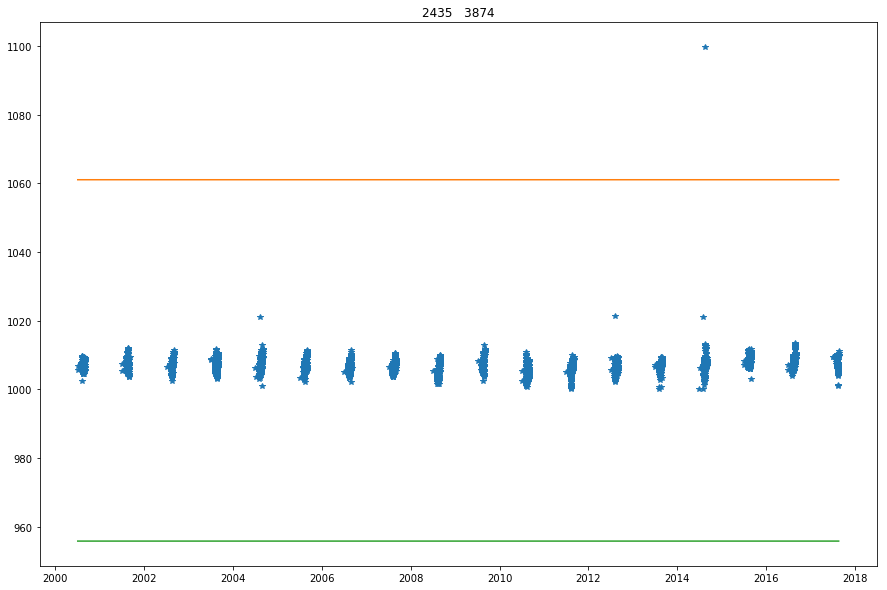

In [34]:
plot_suspicious('pressure',stl[160:200])